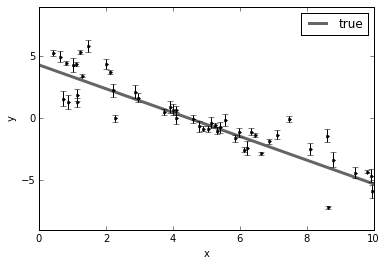

In [62]:
%matplotlib inline
import sys,os
from numpy import array, double, arange, random
try:
    import matk
except:
    try:
        sys.path.append(os.path.join('..','src'))
        import matk
    except ImportError as err:
        print 'Unable to load MATK module: '+str(err)
import numpy
from matplotlib import pyplot as plt
import scipy.optimize as op

def femcee(args,x):
    return args['m']*x+args['b']
    

# Generate some synthetic data from the model.
N = 50
m_true = -0.9594
b_true = 4.294
f_true = 0.534
# Random x values
x = numpy.sort(10*numpy.random.rand(N))

p = matk.matk(model=femcee,model_args=[x])
# Slope parameter
p.add_par('m', value=m_true, min=-5., max=0.5)
# Intercept parameter
p.add_par('b', value=b_true, min=0., max=10.)
# Fraction of measurement error that is unknown
p.add_par('f', value=f_true, min=-10., max=1.)
p.forward()
y = p.simvalues

# Known error in measurements
yerr = 0.1+0.5*numpy.random.rand(N)
# Add error that is not known in measurements
ferr = numpy.abs(0.534*y)
# Add error that is not known in measurements
y += ferr * numpy.random.randn(N)
# Add known error
y += yerr * numpy.random.randn(N)
xl = numpy.array([0, 10])
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6,label='true')
plt.ylim(-9, 9)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [63]:
def lnprior(theta,p):
    m, b, lnf = theta
    if p.pars['m'].min < m < p.pars['m'].max and p.pars['b'].min < b < p.pars['b'].max and p.pars['f'].min < lnf < p.pars['f'].max:
        return 0.0
    return -numpy.inf

def lnlike(theta, x, y, yerr, matk_prob):
    m, b, lnf = theta
    #m = theta['m']
    #b = theta['b']
    #lnf = numpy.log10(lnf)
    model = matk_prob.forward(pardict=dict(zip(matk_prob.parnames,[m,b])))
    model = matk_prob.simvalues
    inv_sigma2 = 1.0/(yerr**2 + model**2*numpy.exp(2*lnf))
    return -0.5*(numpy.sum((y-model)**2*inv_sigma2 - numpy.log(inv_sigma2)))

def lnprob(theta, x, y, yerr, matk_prob):
    lp = lnprior(theta,matk_prob)
    if not numpy.isfinite(lp):
        return -numpy.inf
    return lp + lnlike(theta, x, y, yerr, matk_prob)


In [64]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [p.pars['m'].value, p.pars['b'].value, numpy.log(p.pars['f'].value)], args=(x, y, yerr,p))
m_ml, b_ml, lnf_ml = result["x"]
print m_ml,b_ml,lnf_ml

-0.986924218117 4.43349630736 -0.773746108994


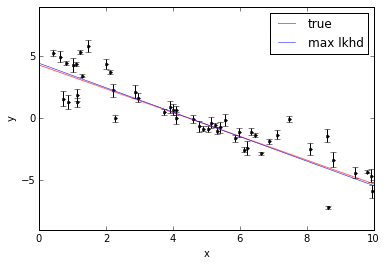

In [65]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(xl, m_true*xl+b_true, "r", lw=1, alpha=0.6,label='true')
plt.plot(xl, m_ml*xl+b_ml, "b", lw=0.5,label='max lkhd')
plt.ylim(-9, 9)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [66]:
pos = [result["x"] + 1e-4*numpy.random.randn(len(p.pars)) for i in range(100)]
ss = p.emcee(lnprob=lnprob,lnprob_args=(x,y,yerr,p),nwalkers=100,nsamples=1000,burnin=100,pos0=pos)

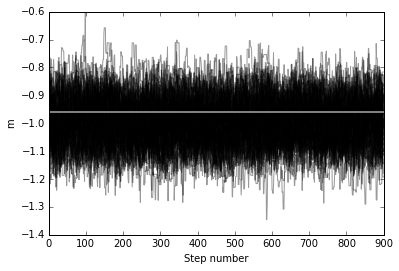

In [67]:
plt.plot(ss.chain[:,100:,0].T,color='k',alpha=0.4)
plt.axhline(m_true, color='gray', lw=2)
plt.xlabel('Step number')
plt.ylabel('m')

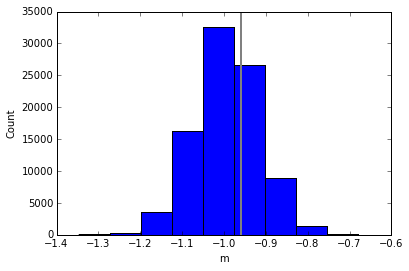

In [68]:
plt.hist(ss.chain[:,100:,0].reshape((-1,1)))
plt.axvline(m_true, color='gray', lw=2)
plt.xlabel('m')
plt.ylabel('Count')

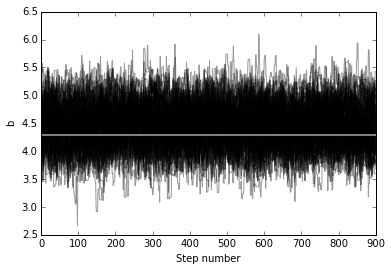

In [69]:
plt.plot(ss.chain[:,100:,1].T,color='k',alpha=0.4)
plt.axhline(b_true, color='gray', lw=2)
plt.xlabel('Step number')
plt.ylabel('b')

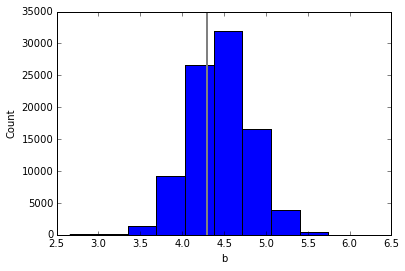

In [70]:
plt.hist(ss.chain[:,100:,1].reshape((-1,1)))
plt.axvline(b_true, color='gray', lw=2)
plt.xlabel('b')
plt.ylabel('Count')

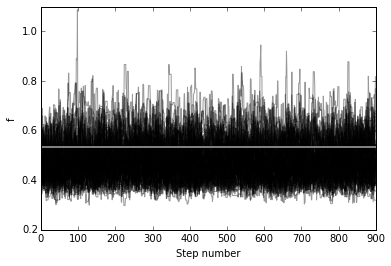

In [71]:
plt.plot(numpy.exp(ss.chain[:,100:,2]).T,color='k',alpha=0.4)
plt.axhline(f_true, color='gray', lw=2)
plt.xlabel('Step number')
plt.ylabel('f')

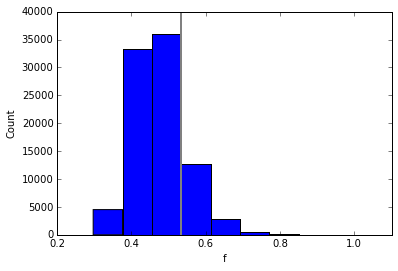

In [72]:
plt.hist(numpy.exp(ss.chain[:,100:,2]).reshape((-1,1)))
plt.axvline(f_true, color='gray', lw=2)
plt.xlabel('f')
plt.ylabel('Count')